In [1]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import numpy as np
import os
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split, Dataset
from torchvision.io import read_image
from torch.autograd import Variable

2024-01-12 17:40:33.496692: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 17:40:33.668158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 17:40:33.668205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 17:40:33.693715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 17:40:33.751391: I tensorflow/core/platform/cpu_feature_guar

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
train_path = glob("./archive/cityscapes_data/train/*")
valid_path = glob("./archive/cityscapes_data/val/*")

In [10]:
train_dataset = []
valid_dataset = []
#torch.utils.data.Dataset/Dataloader
class dataset(Dataset):
    def __init__(self, image_path, transform_img = None, transform_label = None):
        self.image_path = image_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img = plt.imread(self.image_path[idx])

        image, label = img[:,:img.shape[1]//2], img[:,img.shape[1]//2:]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [11]:
z_size = 10 # Size of z latent vector (i.e. size of generator input)
img_size = 64
ngpu = 16 # Number of GPUs available
nc = 3   # Number of channels in the training images. For color images this is 3

In [12]:
myTransformImage = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
#     transform.RandomHorizontalFlip(p = 0.9)
])

myTransformLabel = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
])

In [13]:
train_dataset = dataset(train_path, myTransformImage, myTransformLabel)
valid_dataset = dataset(valid_path, myTransformImage, myTransformLabel)


# Batches
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True)

In [14]:
#Print batch
def show_batch(whole_batch):
    images, ground_truths = whole_batch[0], whole_batch[1]
    images = images.numpy()
    ground_truths = ground_truths.numpy()
    fig, axes = plt.subplots(2, batch_size, figsize=(36, 4))

    for i in range(batch_size):
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Input{i}')

        axes[1, i].imshow(np.transpose(ground_truths[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Output{i}')

    plt.show()

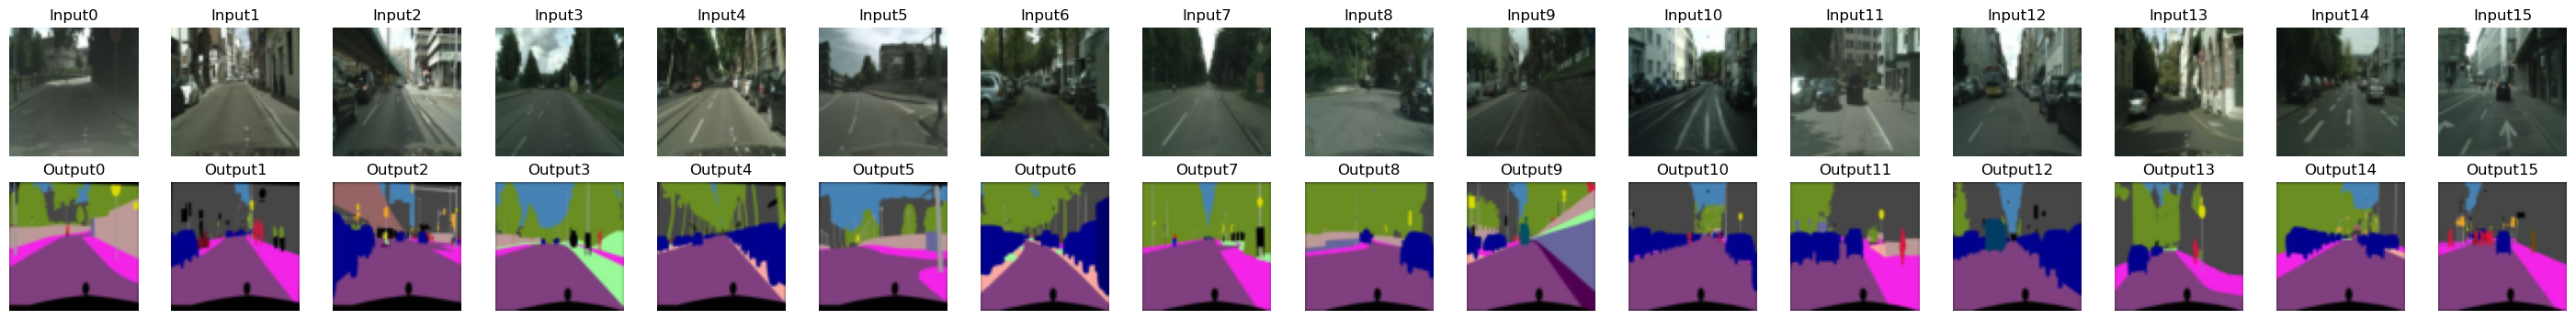

In [15]:
data_iter = iter(train_loader)
show_batch(next(data_iter))

In [16]:
#visualize images, pass the list

def show(pckt):

    iters = 1
    if len(pckt[0].shape) > 3:
        iters = pckt[0].shape[0]
        for j in range(iters):
            img = [None]*3
            n = 3
            labels = ['Label', 'Real', 'Predicted']
            fig, ax = plt.subplots(1, n, figsize=(10, 30))
            for i in range(n):

                x = torch.Tensor.cpu(pckt[j][i])
                x = x.detach().numpy()
                ax[i].imshow(np.transpose(x,(1,2,0)))
                ax[i].set_title(labels[i])
    else:
        img = [None]*3
        n = len(pckt)
        labels = ['Input', 'Output', 'Predicted']
        fig, ax = plt.subplots(1, n, figsize=(10, 30))
        for i in range(n):
            x = torch.Tensor.cpu(pckt[i])
            x = x.detach().numpy()
            ax[i].imshow(np.transpose(x,(1,2,0)))
            ax[i].set_title(labels[i])

torch.Size([16, 3, 64, 64])


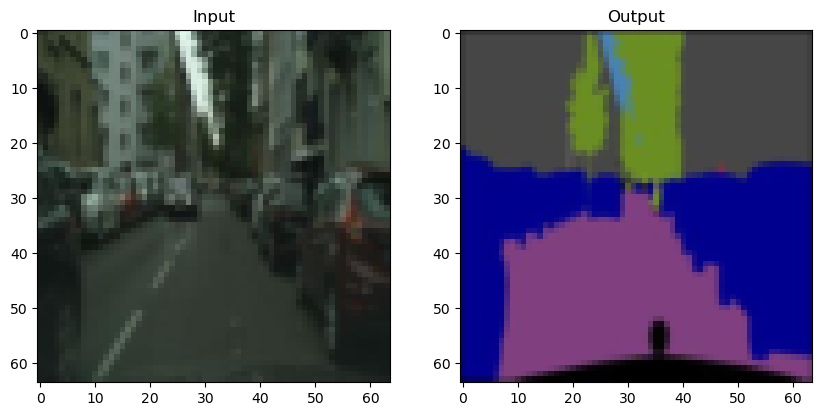

In [17]:
data_iter = iter(train_loader)
input, output = next(data_iter)

show([input[0], output[0]])
print(input.shape)

In [18]:
ngf = 64
class Generator(nn.Module):
    def __init__(self,ngf, img_size, nc):
        super().__init__()
        self.nc = nc
        self.img_size = img_size
        self.ngf = ngf

        self.downSampling = nn.Sequential(
            nn.Conv2d(nc, self.ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 2, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 4, self.ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 8, self.ngf * 16, 4, 1, 0, bias=False),
        )

        self.upSampling = nn.Sequential(
            nn.ConvTranspose2d( self.ngf * 16, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):

        x = self.downSampling(input)
        # print(x.shape)

        # Generator out
        out = self.upSampling(x)
        # print(out.shape)
        return out
myGenerator = Generator(ngf, img_size, nc).to(device)

16


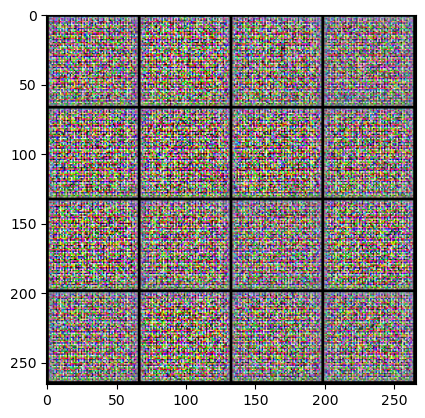

In [19]:
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
# print(random_noise.shape)
# print(img_label.view(16, -1).shape)
# Forward pass through the generator
generated_image = myGenerator(input).data.cpu()
# print(generated_image.shape)
print(len(generated_image))
# Show images
grid = make_grid(generated_image, nrow=4, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

In [20]:
ndf = 64
class Discriminator(nn.Module):
    def __init__(self, ngpu, img_size, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.img_size = img_size
        self.nc = nc

        self.main = nn.Sequential(

            nn.Conv2d(nc*2, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x, labels):

        # Concat image & label
        x = torch.cat([x, labels], 1)
        # print(x.shape)
        # Discriminator out
        out = self.main(x)
        # print(out.shape)
        return out.view(-1,1,1,1)


myDiscriminator = Discriminator(ngpu, img_size, nc).to(device)

In [21]:
# Generate random noise and labels
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
output = output.to(device)
# Forward pass through the generator
generated_image = myGenerator(input).data.cpu().to(device)
# Disciminating fake images
fake_validity = myDiscriminator(input, generated_image)
print(fake_validity.shape)

torch.Size([16, 1, 1, 1])


In [ ]:
def weights_init(m):  #custom weights initialization called on myGenerator and myDiscriminator
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

myGenerator.apply(weights_init)
myDiscriminator.apply(weights_init)

In [ ]:
# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(myDiscriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = optim.Adam(myGenerator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# Initialize BCELoss function
criterion  = nn.BCELoss()

In [ ]:
#Training GAN
print("Starting Training Loop...")

n_of_epochs = 110
loss_Discriminator = 0

for e in range(n_of_epochs):
    running_loss_D = 0.0
    print('Starting epoch {}...'.format(e+1))
    for i, (input,output) in enumerate(train_loader, 0):

    #####################################################################
    ## Update Discriminator: maximize log(D(x/y)) + log(1 - D(G(z/y))) ##
    #####################################################################

        #Loss on real Images
        myDiscriminator.zero_grad()
        predicted = myDiscriminator(input.to(device),output.to(device))
        loss_real = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_real.backward(retain_graph=True)

        #Loss on fake Images
        fake_output = myGenerator(input.to(device))
        predicted = myDiscriminator(input.to(device),fake_output.to(device))
        loss_fake = criterion(predicted, torch.zeros((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_fake.backward(retain_graph=True)
        loss_Discriminator = loss_real + loss_fake
        d_optimizer.step()

        #################################################
        ### Update Generator: maximize log(D(G(z/y))) ###
        #################################################

        myGenerator.zero_grad()
        predicted = myDiscriminator(input.to(device),fake_output.to(device))
        loss_gen = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_gen.backward()
        g_optimizer.step()
        running_loss_D +=  loss_Discriminator.item()
    # Set generator eval

    print('g_loss: {}, d_loss: {}'.format(loss_gen, loss_Discriminator))

    # Generate random noise and labels
    data_iter = iter(train_loader)
    input, output = next(data_iter)
    input = input.to(device)
    output = output.to(device)
    # Forward pass through the generator
    generated_image = myGenerator(input).data.cpu().to(device)
    show([input[0], output[0], generated_image[0]])
    plt.show()

In [21]:
torch.save(myGenerator.state_dict(), '/content/drive/MyDrive/cGAN_Gen_segmentation.pth')
torch.save(myDiscriminator.state_dict(), '/content/drive/MyDrive/cGAN_Dis_segmentation.pth')

In [24]:
loaded_Generator = Generator(ngf, img_size, nc).to(device)
loaded_Generator.load_state_dict(torch.load('./cGAN_Gen_segmentation.pth', map_location=torch.device('cpu') ))

loaded_Discriminator = Discriminator(ngpu, img_size, nc).to(device)
loaded_Discriminator.load_state_dict(torch.load('./cGAN_Dis_segmentation.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


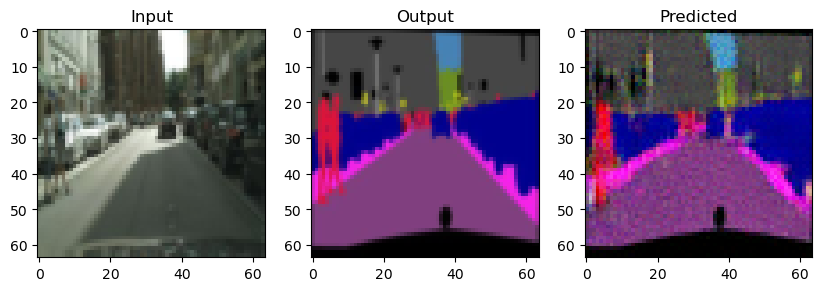

Pixel-wise Accuracy on Trainset: 43.19%


In [25]:
def pixel_wise_accuracy(prediction, target):
    """
    Compute Pixel-wise Accuracy.

    Args:
        prediction (numpy array or torch tensor): Predicted labels.
        target (numpy array or torch tensor): Ground truth labels.

    Returns:
        float: Pixel-wise Accuracy.
    """
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()

    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()

    lower_bound = -7/255
    upper_bound = 7/255

    correct_pixels = np.sum((prediction >= target + lower_bound) & (prediction <= target + upper_bound))
    total_pixels = np.prod(prediction.shape)


    return correct_pixels / total_pixels

#Generate random noise and labels
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
output = output.to(device)
#Forward pass through the generator
generated_image = loaded_Generator(input).data.cpu().to(device)
show([input[0], output[0], generated_image[0]])
plt.show()
#Compute Pixel Accuracy
accuracy = pixel_wise_accuracy(generated_image, output)

print(f"Pixel-wise Accuracy on Trainset: {accuracy * 100:.2f}%")

In [26]:
accuracies = []
count_data = []
for i, (input,output) in enumerate(train_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = loaded_Generator(input).data.cpu().to(device)

  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on Trainset: {total_accuracy * 100:.2f}%")

Pixel-wise Accuracy on Trainset: 46.41%


In [27]:
accuracies = []
count_data = []
for i, (input,output) in enumerate(valid_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = loaded_Generator(input).data.cpu().to(device)

  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on Validationset: {total_accuracy * 100:.2f}%")

Pixel-wise Accuracy on Validationset: 37.26%
